# Customer Segmentation




In [101]:
"""
Customer Segmentation Script (Mixed Data Clustering)
This script performs customer segmentation using clustering techniques on a dataset containing both numerical and categorical features.
The script includes data preprocessing, clustering using K-Means, K-Prototypes, and visualization of the resulting clusters.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from kmodes.kprototypes import KPrototypes
import gower
from scipy.cluster.hierarchy import dendrogram, linkage
from kneed import KneeLocator
import joblib

warnings.filterwarnings('ignore')
sns.set_style('ticks')
sns.set_palette('Set2')
sns.set_context('poster')
plt.rc('font', size=14, weight='bold')
plt.rc('axes', labelsize=14, titlesize=14, labelweight='bold')
plt.rc('legend', fontsize=14, title_fontsize=16)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# =============================================================================
# Configuration
# =============================================================================
SAMPLE_SIZE = 20000  # Number of rows to use for Gower and silhouette (adjust based on memory)
RANDOM_STATE = 45

# Create output directory
output_dirs=['plots_segmentation_outputs', 'model_segmentation_outputs']
for dir in output_dirs:
    os.makedirs(dir, exist_ok=True)


## Load and Clean the Datasets

In [102]:
# =============================================================================
# Load and Clean Data
# =============================================================================
# =============================================================================
# Load the dataset columns
col_filename = 'census-bureau.columns'
# Load column names
with open(col_filename, 'r') as f:
    column_list = [line.strip() for line in f.readlines()]
print(column_list)

# Load the dataset
filename = 'census-bureau.data'
data = pd.read_csv(filename, header=None, names=column_list)



df = data.drop_duplicates(ignore_index=True)

df['label'] = df['label'].replace({'- 50000.':'<=50K', '50000+.':'>50K'})
# Display basic info
print("Data loaded. Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())

# Dataset Summary
print("\nDataset Summary:")
print(df.info())

# Dataset Summary Statistics
print("\nSummary Statistics:")
print(df.describe(include='all'))


# Clean target
# Map label to binary
df['income'] = df['label'].apply(lambda x: 1 if x.strip() == '>50K' else 0)
print(df['income'].value_counts(normalize=True))

# Replace '?' , 'Not in universe or children', 'Not in universe under 1 year old', and 'Not in universe' with NaN for easier handling
na_values = ['?', 'Not in universe']
df.replace(na_values, np.nan, inplace=True)


['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'weight', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', "fill inc questionnaire for veteran's admin", 'veterans benefits', 'weeks worked 

### Drop High Missing Columns

In [103]:
# =============================================================================
# Drop high-missing columns
# =============================================================================
fraction = 90
missing_frac = (df.isnull().mean()*100).sort_values(ascending=False)
print(f"Columns with >{fraction}% missing:\n", missing_frac[missing_frac > fraction])
high_missing_cols = missing_frac[missing_frac > fraction].index.tolist()
df.drop(columns=high_missing_cols, inplace=True)
print(f"Dropped {len(high_missing_cols)} columns with >{fraction}% missing.")
print(f"Dropped columns: {high_missing_cols}")
print("Remaining columns:", df.columns.tolist())
print("\nMissing Values After Dropping:\n", df.isnull().sum())


Columns with >90% missing:
 fill inc questionnaire for veteran's admin    98.989271
reason for unemployment                       96.908719
enroll in edu inst last wk                    93.615699
state of previous residence                   92.345665
region of previous residence                  91.985491
migration prev res in sunbelt                 91.985491
member of a labor union                       90.289056
dtype: float64
Dropped 7 columns with >90% missing.
Dropped columns: ["fill inc questionnaire for veteran's admin", 'reason for unemployment', 'enroll in edu inst last wk', 'state of previous residence', 'region of previous residence', 'migration prev res in sunbelt', 'member of a labor union']
Remaining columns: ['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'full or part time employment stat', 'capital gains'

### Feature Selection

In [104]:
# =============================================================================
# Feature Selection
# =============================================================================
# Features: all except label, income, weight
X = df.drop(['label', 'income', 'weight'], axis=1, errors='ignore')

# =============================================================================
# Preprocessing
# =============================================================================
# Separate numeric and categorical
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Impute numeric with median
num_imputer = SimpleImputer(strategy='median')
X[numeric_cols] = num_imputer.fit_transform(X[numeric_cols])

# Impute categorical with most frequent
cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

# Scale numeric features
scaler = StandardScaler()
X_scaled_numeric = scaler.fit_transform(X[numeric_cols])
X_scaled = X.copy()
X_scaled[numeric_cols] = X_scaled_numeric

# For K-Means: one-hot encode categorical after imputation
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X[categorical_cols])
# Combine scaled numeric with encoded categorical
X_kmeans = np.hstack([X_scaled_numeric, X_encoded])
print("K-Means input shape:", X_kmeans.shape)

# Applying PCA for K-Means to reduce dimensionality and computational times
pca_kmeans = PCA(n_components=0.95, random_state=RANDOM_STATE)  # Keep 95% variance
X_kmeans_pca = pca_kmeans.fit_transform(X_kmeans)
print(f"K-Means PCA reduced to {X_kmeans_pca.shape[1]} components (95% variance)")


K-Means input shape: (196294, 319)
K-Means PCA reduced to 61 components (95% variance)


### Compute the Gower Distance Matrix 

In [105]:
# =============================================================================
# Compute Gower distance matrix (common evaluation metric)
# =============================================================================

n_total = X.shape[0]
sample_size = min(SAMPLE_SIZE, n_total)
print(f"\nTaking a random sample of {sample_size} rows for Gower and silhouette...")
np.random.seed(RANDOM_STATE)
sample_idx = np.random.choice(n_total, size=sample_size, replace=False)

X_sample = X.iloc[sample_idx].copy()  # original (unscaled) for Gower
X_scaled_sample = X_scaled.iloc[sample_idx].copy()  # scaled for K-Prototypes
X_kmeans_sample = X_kmeans[sample_idx]  # already computed

# For Gower, we need original (not scaled) as it normalizes internally
print("Computing Gower distance matrix on sample (this may take a few minutes)...")
gower_dist_sample = gower.gower_matrix(X_sample)  # shape (sample_size, sample_size)
print("Gower matrix shape:", gower_dist_sample.shape)



Taking a random sample of 20000 rows for Gower and silhouette...
Computing Gower distance matrix on sample (this may take a few minutes)...
Gower matrix shape: (20000, 20000)


## Clustering and Evaluation

In [106]:
# =============================================================================
# Clustering and Evaluation
# =============================================================================
# Function to find optimal k using KneeLocator
def get_optimal_k(k_values, cost_list):
    """
    k_values: list of k (e.g., [2, 3, 4, ...])
    cost_list: list of cost values (Inertia, WCSS, etc.)
    """
    kn = KneeLocator(k_values, cost_list, curve='convex', direction='decreasing')
    return kn.elbow


In [107]:
# =============================================================================
# Determine Optimal Number of Clusters for each method
# =============================================================================
k_range = range(2, 11)
results = {
    'kmeans': {'silhouette': [], 'inertia': []},
    'kprototypes': {'silhouette': [], 'cost': []},
    'gower_agg': {'silhouette': [], 'inertia': []}
}

k_optimal = []

# K-Means (fit on full data, evaluate silhouette on sample using Gower distances)
print("\n=== K-Means Clustering ===")
# For each k, fit K-Means on full PCA-reduced data, then predict sample labels
# and compute silhouette using precomputed Gower distance for sample.
for k in k_range:
    print(f"K-Means k={k}...")
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    km.fit(X_kmeans_pca)  # fit on full
    # Predict on sample (need to project sample through PCA)
    X_kmeans_pca_sample = pca_kmeans.transform(X_kmeans[sample_idx])
    labels_sample = km.predict(X_kmeans_pca_sample)
    sil = silhouette_score(gower_dist_sample, labels_sample, metric='precomputed')
    results['kmeans']['silhouette'].append(sil)
    results['kmeans']['inertia'].append(km.inertia_)
    print(f"Silhouette = {sil:.4f}")
results['kmeans']['optimal_k'] = get_optimal_k(k_range, results['kmeans']['inertia'])
k_optimal.append(results['kmeans']['optimal_k'])

# K-Prototypes (fit on full scaled data, evaluate on sample)
print("\n=== K-Prototypes Clustering ===")
cat_cols_idx = [X_scaled.columns.get_loc(c) for c in categorical_cols]
# For sample, we need indices relative to X_scaled_sample (same column order)
cat_cols_idx_sample = [X_scaled_sample.columns.get_loc(c) for c in categorical_cols]

for k in k_range:
    print(f"K-Prototypes k={k}...")
    kp = KPrototypes(n_clusters=k, init='Huang', random_state=RANDOM_STATE, verbose=0, n_jobs=-1)
    kp.fit(X_scaled, categorical=cat_cols_idx)  # fit on full
    # Predict on sample
    labels_sample = kp.predict(X_scaled_sample, categorical=cat_cols_idx_sample)
    results['kprototypes']['cost'].append(kp.cost_)
    sil = silhouette_score(gower_dist_sample, labels_sample, metric='precomputed')
    results['kprototypes']['silhouette'].append(sil)
    print(f"Silhouette = {sil:.4f}")

results['kprototypes']['optimal_k'] = get_optimal_k(k_range, results['kprototypes']['cost'])
k_optimal.append(results['kprototypes']['optimal_k'])

# Gower + K Medoids (fit on sample only, since it needs full distance matrix)
print("\n=== Gower + K Medoids Clustering ===")
for k in k_range:
    print(f"K-Medoids k={k}...")
    kmed = KMedoids(n_clusters=k, metric='precomputed', random_state=RANDOM_STATE)
    labels_sample = kmed.fit_predict(gower_dist_sample)
    sil = silhouette_score(gower_dist_sample, labels_sample, metric='precomputed')
    results['gower_agg']['silhouette'].append(sil)
    results['gower_agg']['inertia'].append(kmed.inertia_)
    print(f"Silhouette = {sil:.4f}")

results['gower_agg']['optimal_k'] = get_optimal_k(k_range, results['gower_agg']['inertia'])
k_optimal.append(results['gower_agg']['optimal_k'])




=== K-Means Clustering ===
K-Means k=2...
Silhouette = 0.2911
K-Means k=3...
Silhouette = 0.2423
K-Means k=4...
Silhouette = 0.2782
K-Means k=5...
Silhouette = 0.1753
K-Means k=6...
Silhouette = 0.2297
K-Means k=7...
Silhouette = 0.2039
K-Means k=8...
Silhouette = 0.2237
K-Means k=9...
Silhouette = 0.2071
K-Means k=10...
Silhouette = 0.2025

=== K-Prototypes Clustering ===
K-Prototypes k=2...
Silhouette = 0.2899
K-Prototypes k=3...
Silhouette = 0.2357
K-Prototypes k=4...
Silhouette = 0.1768
K-Prototypes k=5...
Silhouette = 0.1669
K-Prototypes k=6...
Silhouette = 0.1745
K-Prototypes k=7...
Silhouette = 0.1590
K-Prototypes k=8...
Silhouette = 0.1431
K-Prototypes k=9...


Exception ignored in: <function ResourceTracker.__del__ at 0x106f21da0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


Silhouette = 0.1815
K-Prototypes k=10...
Silhouette = 0.1520

=== Gower + K Medoids Clustering ===
K-Medoids k=2...
Silhouette = 0.2482
K-Medoids k=3...
Silhouette = 0.2140
K-Medoids k=4...
Silhouette = 0.1959
K-Medoids k=5...
Silhouette = 0.2044
K-Medoids k=6...
Silhouette = 0.1900
K-Medoids k=7...
Silhouette = 0.1640
K-Medoids k=8...
Silhouette = 0.2162
K-Medoids k=9...
Silhouette = 0.2132
K-Medoids k=10...
Silhouette = 0.1649


In [108]:
# =============================================================================
# Plot Silhouette Scores Comparison
# =============================================================================
plt.figure(figsize=(12,6))
plt.plot(k_range, results['kmeans']['silhouette'], 'go-', label='K-Means (PCA+OneHot)')
plt.plot(k_range, results['kprototypes']['silhouette'], 'bo-', label='K-Prototypes')
plt.plot(k_range, results['gower_agg']['silhouette'], 'rs-', label='Gower+Kmediods')
plt.xlabel('Number of clusters (k)', fontsize=14, fontweight='bold')
plt.ylabel('Silhouette Score (on sample Gower distance)', fontsize=14, fontweight='bold')
plt.title('Clustering Algorithms Silhouette Score Comparison', fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
plt.grid(True)
plt.savefig(f'{output_dirs[0]}/silhouette_comparison.png')
plt.close()

# Plot K-Means inertia elbow
plt.figure(figsize=(8,5))
plt.plot(k_range, results['kmeans']['inertia'], 'mo-', label='K-Means (PCA+OneHot)')
#plt.axvline(x=results['kmeans']['optimal_k'], color='m', linestyle='--', label=f'Optimal k={results["kmeans"]["optimal_k"]}')
plt.xlabel('Number of clusters (k)', fontsize=14, fontweight='bold')
plt.ylabel('Inertia', fontsize=14, fontweight='bold')
plt.title('Clustering Algorithms K-Means Elbow (full data)', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()
plt.savefig(f'{output_dirs[0]}/kmeans_elbow.png')
plt.close()

# Plot K-Prototypes cost elbow
plt.figure(figsize=(8,5))
plt.plot(k_range, results['kprototypes']['cost'], 'co-', label='K-Prototypes')
#plt.axvline(x=results['kprototypes']['optimal_k'], color='c', linestyle='--', label=f'Optimal k={results["kprototypes"]["optimal_k"]}')
plt.xlabel('Number of clusters (k)', fontsize=14, fontweight='bold')
plt.ylabel('Cost', fontsize=14, fontweight='bold')
plt.title('K-Prototypes Elbow (full data)', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()
plt.savefig(f'{output_dirs[0]}/kprototypes_elbow.png')
plt.close()

# Plot Gower+Agg inertia elbow
plt.figure(figsize=(8,5))
plt.plot(k_range, results['gower_agg']['inertia'], 'rs-', label='Gower+Kmediods')
#plt.axvline(x=results['gower_agg']['optimal_k'], color='r', linestyle='--', label=f'Optimal k={results["gower_agg"]["optimal_k"]}')
plt.xlabel('Number of clusters (k)', fontsize=14, fontweight='bold')
plt.ylabel('Inertia', fontsize=14, fontweight='bold')
plt.title('Gower+Agglomerative Elbow (sample data)', fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()
plt.savefig(f'{output_dirs[0]}/gower_agg_elbow.png')
plt.close()


In [109]:
# =============================================================================
# Select Best Method and k based on silhouette
# =============================================================================
best_method = None
best_k = None  # Start with smallest optimal k among methods
best_sil = -1
for method in results:
    sil_scores = results[method]['silhouette']
    max_idx = np.argmax(sil_scores)  # index of max silhouette for this method
    if sil_scores[max_idx] > best_sil:
        best_sil = sil_scores[max_idx]
        best_method = method
        best_k = k_range[max_idx]

print("\n=== Best Silhouette Scores ===")
print(f"\nSelected method: {best_method} with k={best_k}, silhouette={best_sil:.4f}")



=== Best Silhouette Scores ===

Selected method: kmeans with k=2, silhouette=0.2911


In [110]:
# =============================================================================
# Cluster Analysis (function)
# =============================================================================
def create_cluster_summary(df_clust):
    categorical_for_mode = ['sex', 'race', 'marital stat', 'education', 'class of worker', 'major occupation code']
    categorical_for_mode = [c for c in categorical_for_mode if c in df_clust.columns]
    numeric_for_mean = ['age', 'wage per hour', 'capital gains', 'weeks worked in year', 'num persons worked for employer']
    numeric_for_mean = [c for c in numeric_for_mean if c in df_clust.columns]

    summary = df_clust.groupby('cluster').agg(
        {col: lambda x: x.mode()[0] if not x.mode().empty else np.nan for col in categorical_for_mode}
    )
    for col in numeric_for_mean:
        summary[col] = df_clust.groupby('cluster')[col].mean()
    summary['size'] = df_clust.groupby('cluster').size()
    summary['high_income_pct'] = df_clust.groupby('cluster')['income'].mean() * 100
    return summary.reset_index()

# =============================================================================
def name_clusters(df):
    cluster_names = {}
    for i in range(4):
        subset = df[df['cluster'] == i]
        mean_age = subset['age'].mean()
        high_income_rate = subset['income'].mean()

        # JPMC Business Logic
        if high_income_rate > 0.10:
            name = "Established Affluent" if mean_age > 45 else "Young Professionals"
        else:
            if mean_age > 55:
                name = "Retirees / Seniors"
            elif mean_age < 30:
                name = "Early Career / Students"
            else:
                name = "Working Class / Mainstream"
        cluster_names[i] = name
    return cluster_names


In [111]:
# =============================================================================
# Fit final model with best method and k on full data
# =============================================================================
if best_method == 'kmeans':
    final_clusterer = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
    final_labels = final_clusterer.fit_predict(X_kmeans_pca)
    joblib.dump(final_clusterer, f'{output_dirs[1]}/best_segmentation_model.pkl')
elif best_method == 'kprototypes':
    final_clusterer = KPrototypes(n_clusters=best_k, init='Huang', random_state=RANDOM_STATE, n_jobs=-1)
    final_labels = final_clusterer.fit_predict(X_scaled, categorical=cat_cols_idx)
    joblib.dump(final_clusterer, f'{output_dirs[1]}/best_segmentation_model.pkl')
else:  # gower_agg
    # For KMediods, we cannot fit on full data due to memory; we'll use the sample as a representative model.
    print("\nWarning: Gower+K Medoids cannot be scaled to full data. Using sample-based model.")
    final_clusterer = KMedoids(n_clusters=best_k, metric='precomputed', random_state=RANDOM_STATE)
    final_labels_sample = final_clusterer.fit_predict(gower_dist_sample)
    joblib.dump({'labels_sample': final_labels_sample, 'k': best_k, 'method': best_method,
                 'sample_idx': sample_idx}, f'{output_dirs[1]}/best_segmentation_model.pkl')
    # For cluster analysis, we'll use the sample labels only
    df_sample = df.iloc[sample_idx].copy()
    df_sample['cluster'] = final_labels_sample
    cluster_summary = create_cluster_summary(df_sample)  # define function below
    persona_map = name_clusters(df_sample)
    df_sample['Marketing_Persona'] = df_sample['cluster'].map(persona_map)
    cluster_summary.to_csv(f'{output_dirs[0]}/cluster_profiles.csv', index=False)
    print("\nCluster profiles based on sample only.")
    # Skip adding cluster to full df
    #print("Segmentation completed. Note: For Gower+KMedoids, cluster labels are only for the sample.")




In [112]:
# =============================================================================
# Create cluster summary and assign persona names
# =============================================================================
if best_method == 'gower_agg':
    print("\nWarning: Gower+kmedoids cannot be scaled to full data. Using sample-based model.")  # IGNORE
    cluster_data = df_sample.copy()
else:
    cluster_data = df.copy()
    # Add cluster labels to original dataframe (for scalable methods)
    cluster_data['cluster'] = final_labels
    cluster_summary = create_cluster_summary(cluster_data)


    persona_map = name_clusters(cluster_data)
    cluster_data['Marketing_Persona'] = cluster_data['cluster'].map(persona_map)

    print("\nCluster Profiles:")
    print(cluster_summary.to_string())
    cluster_summary.to_csv(f'{output_dirs[0]}/cluster_profiles.csv', index=False)
    cluster_data[['cluster']].to_csv(f'{output_dirs[0]}/cluster_labels.csv', index=True, header=['cluster'])



Cluster Profiles:
   cluster     sex   race                     marital stat             education class of worker           major occupation code        age  wage per hour  capital gains  weeks worked in year  num persons worked for employer    size  high_income_pct
0        0  Female  White                    Never married              Children         Private                           Sales  30.907213       0.124354      91.525199              0.965390                         0.180054   95638         0.689057
1        1    Male  White  Married-civilian spouse present  High school graduate         Private  Adm support including clerical  38.751202     109.746314     774.749146             45.016283                         3.706019  100656        11.534335


In [113]:
# =============================================================================
# Visualization: 2D PCA projection for best method
# =============================================================================
# PCA Visualization with Classes & Income Labels ---

# Use PCA on the one-hot encoded + scaled numeric data for visualization (full)
pca_vis = PCA(n_components=2, random_state=RANDOM_STATE)
if best_method == 'gower_agg':
    X_vis = pca_vis.fit_transform(X_kmeans_sample)  # Sample Data from K-Means
else:
    X_vis = pca_vis.fit_transform(X_kmeans)  # full data

cluster_data['PCA1'], cluster_data['PCA2'] = X_vis[:, 0], X_vis[:, 1]
plt.figure(figsize=(12,8))
scatter = sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='Marketing_Persona', # Colors by Business Category
    style='label',     # Shapes by Actual Income Class
    data=cluster_data.sample(10000),    # Sample for visual clarity
    palette='Set2',
    alpha=0.7,
    s=50
)
plt.xlabel('PC1', fontsize=14, fontweight='bold')
plt.ylabel('PC2', fontsize=14, fontweight='bold')
plt.title(f'{best_method} Clusters (k={best_k}) | Strategic Client Map: Segments vs. Income Classes',
         fontsize=16, fontweight='bold')
#plt.colorbar(scatter)
plt.legend(title='Personas & Income', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'{output_dirs[0]}/pca_clusters_best.png', dpi=150)
plt.close()

age_fig = sns.catplot(x='Marketing_Persona', y='age', data=cluster_data, kind='box', hue='label',
                       col='sex')
age_fig.set_axis_labels("Marketing Persona", "Age")
age_fig.fig.suptitle("Age Distribution by Marketing Persona", y=1.02, fontsize=16, fontweight='bold')
age_fig.savefig(f'{output_dirs[0]}/age_distribution_by_persona.png', dpi=150)
plt.close()

race_fig = sns.catplot(x='Marketing_Persona', y='age', data=cluster_data, kind='box', hue='label',
                       col='race', col_wrap=3)
race_fig.set_axis_labels("Marketing Persona", "Age")
race_fig.fig.suptitle("Age Distribution by Race and Marketing Persona", y=1.02, fontsize=16, fontweight='bold')
race_fig.savefig(f'{output_dirs[0]}/race_distribution_by_persona.png', dpi=150)
plt.close()

wage_fig = sns.catplot(x='education',  data=cluster_data, kind='count', hue='label',
                       col='Marketing_Persona')
wage_fig.set_axis_labels("Education Level", "Count")
wage_fig.fig.suptitle("Count of Individuals by Education and Marketing Persona",y=1.02, fontsize=16, fontweight='bold')
wage_fig.savefig(f'{output_dirs[0]}/education_distribution_by_persona.png', dpi=150)
plt.close()

wage_sex_fig = sns.catplot(x='Marketing_Persona', y='wage per hour', data=cluster_data, kind='bar', hue='label',
                       col='sex')
wage_sex_fig.set_axis_labels("Marketing Persona", "Wage per Hour")
wage_sex_fig.fig.suptitle("Wage per Hour Distribution by Sex and Marketing Persona", y=1.02, fontsize=16, fontweight='bold')
wage_sex_fig.savefig(f'{output_dirs[0]}/wage_distribution_by_persona_sex.png', dpi=150)
plt.close()


# Plot for other methods' best k (using sample for Gower+Agg)
for method in results:
    #df_g = cluster_data.copy()
    if method == best_method:
        continue
    k_other = k_range[np.argmax(results[method]['silhouette'])]
    if method == 'kmeans':
        df_g = df.copy()
        model = KMeans(n_clusters=k_other, random_state=RANDOM_STATE, n_init=10)
        labels_other = model.fit_predict(X_kmeans_pca)
        X_vis = pca_vis.fit_transform(X_kmeans) # full data for visualization
        df_g['PCA1'], df_g['PCA2'] = X_vis[:, 0], X_vis[:, 1]

    elif method == 'kprototypes':
        df_g = df.copy()
        model = KPrototypes(n_clusters=k_other, init='Huang', random_state=RANDOM_STATE, n_jobs=-1)
        labels_other = model.fit_predict(X_scaled, categorical=cat_cols_idx)
        X_vis = pca_vis.fit_transform(X_kmeans) # use same PCA for visualization to keep axes consistent across methods
        df_g['PCA1'], df_g['PCA2'] = X_vis[:, 0], X_vis[:, 1]
    else:
        # For Gower+Kmediods, we only have sample labels
        df_g = df_sample.copy()
        model = KMedoids(n_clusters=k_other, metric='precomputed', random_state=RANDOM_STATE)
        labels_other = model.fit_predict(gower_dist_sample)
        X_vis = pca_vis.fit_transform(X_kmeans_sample) # use sample PCA for visualization since model is sample-based
        df_g['PCA1'], df_g['PCA2'] = X_vis[:, 0], X_vis[:, 1]


    df_g['cluster'] = labels_other
    persona_map_g = name_clusters(df_g)
    df_g['Marketing_Persona'] = df_g['cluster'].map(persona_map_g)
    plt.figure(figsize=(12,8))
    scatter = sns.scatterplot(
        x='PCA1', y='PCA2',
        hue='Marketing_Persona', # Colors by Business Category
        style='label',     # Shapes by Actual Income Class
        data=df_g.sample(10000),    # Sample for visual clarity
        palette='Set2',
        alpha=0.7,
        s=50
    )
    plt.xlabel('PC1', fontsize=14, fontweight='bold')
    plt.ylabel('PC2', fontsize=14, fontweight='bold')
    plt.title(f'{method} Clusters (k={k_other}) in PCA Space', fontsize=16, fontweight='bold')
    #plt.colorbar()
    plt.legend(title='Personas & Income', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{output_dirs[0]}/pca_clusters_{method}.png', dpi=150)
    plt.close()



print(f"\nSegmentation completed. Cluster labels saved in '{output_dirs[0]}/cluster_labels.csv'.")
print(f"Cluster profiles saved in '{output_dirs[0]}/cluster_profiles.csv'.")
print("PCA cluster plots saved.")



Segmentation completed. Cluster labels saved in 'plots_segmentation_outputs/cluster_labels.csv'.
Cluster profiles saved in 'plots_segmentation_outputs/cluster_profiles.csv'.
PCA cluster plots saved.


In [114]:
# Income Rate per cluster
cluster_income = cluster_data.groupby('cluster')['income'].count()/cluster_data.shape[0] * 100
print("\nIncome Rate per Cluster:")
print(cluster_income.to_string())



Income Rate per Cluster:
cluster
0    48.721815
1    51.278185


In [115]:
# Numeric features distribution by cluster
numeric_cols = ['age', 'wage per hour', 'capital gains', 'weeks worked in year', 'num persons worked for employer']
for col in numeric_cols:
    plt.figure(figsize=(10,6))
    sns.boxplot(x='Marketing_Persona', y=col, data=cluster_data)
    plt.title(f'{col} Distribution by Marketing Persona', fontsize=16, fontweight='bold')
    plt.xlabel('Marketing Persona', fontsize=14, fontweight='bold')
    plt.ylabel(col, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{output_dirs[0]}/{col}_distribution_by_persona.png', dpi=150)
    plt.close()

# Numeric Feature Means by Cluster
numeric_means = cluster_data.groupby('Marketing_Persona')[numeric_cols].mean()
print("\nNumeric Feature Means by Marketing Persona:")
print(numeric_means.to_string())



Numeric Feature Means by Marketing Persona:
                                  age  wage per hour  capital gains  weeks worked in year  num persons worked for employer
Marketing_Persona                                                                                                         
Working Class / Mainstream  30.907213       0.124354      91.525199              0.965390                         0.180054
Young Professionals         38.751202     109.746314     774.749146             45.016283                         3.706019


In [ ]:
# Education proportion by Cluster
education_counts = cluster_data.groupby(['Marketing_Persona', 'education']).size().unstack(fill_value=0)
education_proportions = education_counts.div(education_counts.sum(axis=1), axis=0)
print("\nEducation Proportions by Marketing Persona:")
print(education_proportions.to_string())

# Class of Worker proportion by Cluster
worker_counts = cluster_data.groupby(['Marketing_Persona', 'class of worker']).size().unstack(fill_value=0)
worker_proportions = worker_counts.div(worker_counts.sum(axis=1), axis=0)
print("\nClass of Worker Proportions by Marketing Persona:")
print(worker_proportions.to_string())

# Marital Status proportion by Cluster
marital_counts = cluster_data.groupby(['Marketing_Persona', 'marital stat']).size().unstack(fill_value=0)
marital_proportions = marital_counts.div(marital_counts.sum(axis=1), axis=0)
print("\nMarital Status Proportions by Marketing Persona:")
print(marital_proportions.to_string())

# Occupation proportion by Cluster
occupation_counts = cluster_data.groupby(['Marketing_Persona', 'major occupation code']).size().unstack(fill_value=0)
occupation_proportions = occupation_counts.div(occupation_counts.sum(axis=1), axis=0)
print("\nOccupation Proportions by Marketing Persona:")
print(occupation_proportions.to_string())

# Sex proportion by Cluster
sex_counts = cluster_data.groupby(['Marketing_Persona', 'sex']).size().unstack(fill_value=0)
sex_proportions = sex_counts.div(sex_counts.sum(axis=1), axis=0)
print("\nSex Proportions by Marketing Persona:")
print(sex_proportions.to_string())





Education Proportions by Marketing Persona:
education                   10th grade  11th grade  12th grade no diploma  1st 2nd 3rd or 4th grade  5th or 6th grade  7th and 8th grade  9th grade  Associates degree-academic program  Associates degree-occup /vocational  Bachelors degree(BA AB BS)  Children  Doctorate degree(PhD EdD)  High school graduate  Less than 1st grade  Masters degree(MA MS MEng MEd MSW MBA)  Prof school degree (MD DDS DVM LLB JD)  Some college but no degree
Marketing_Persona                                                                                                                                                                                                                                                                                                                                                                                                                                   
Working Class / Mainstream    0.045620    0.033648               0.009902        

Exception ignored in: <function ResourceTracker.__del__ at 0x1034ddda0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107021da0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104f59da0>
Traceback (most recent call last

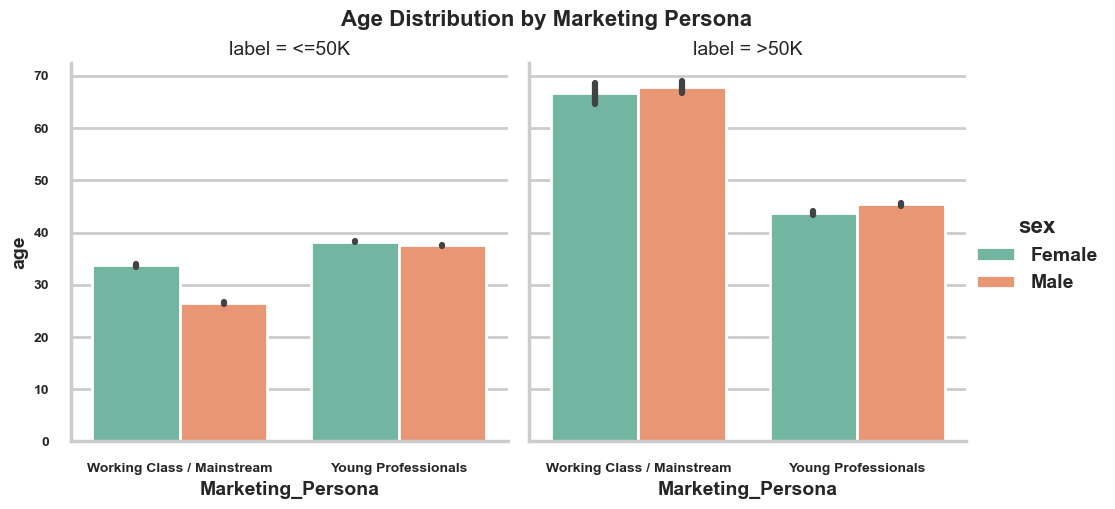

In [117]:
age_fig = sns.catplot(x='Marketing_Persona', y='age', data=cluster_data, kind='bar', hue='sex', col='label')
age_fig.fig.suptitle("Age Distribution by Marketing Persona", y=1.02, fontsize=16, fontweight='bold')
age_fig.savefig(f'{output_dirs[0]}/age_distribution_sex_by_persona.png', dpi=150)



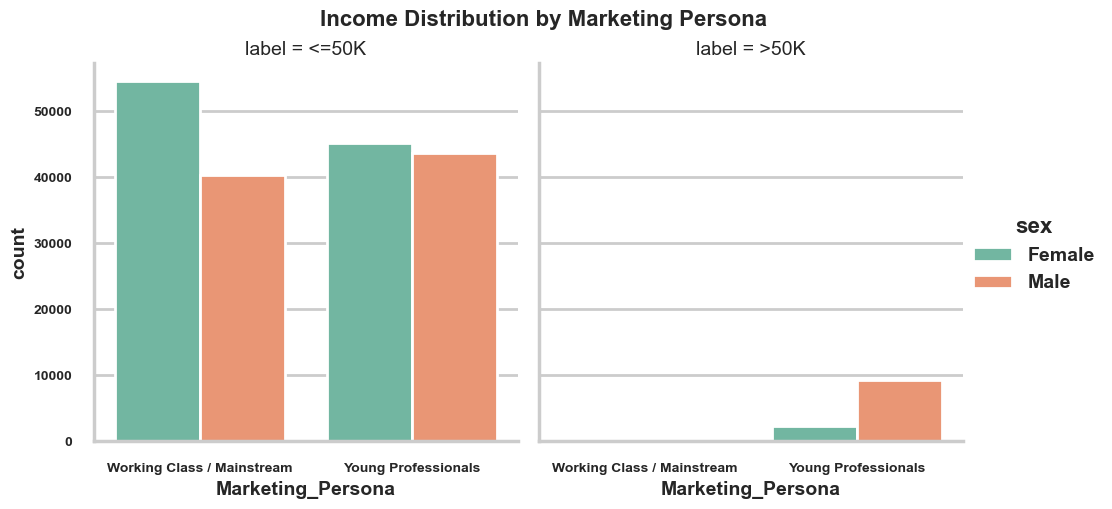

In [118]:
income_fig = sns.catplot(x='Marketing_Persona', data=cluster_data, kind='count', hue='sex', col='label')
income_fig.fig.suptitle("Income Distribution by Marketing Persona", y=1.02, fontsize=16, fontweight='bold')
income_fig.savefig(f'{output_dirs[0]}/income_distribution_sex_by_persona.png', dpi=150)


Domain Insights:
1. The dataset contains a mix of numerical and categorical features, which is common in customer data. This necessitates the use of clustering algorithms that can handle mixed data types, such as K-Prototypes and Gower distance-based methods.
2. The target variable 'income' is binary, indicating whether an individual's income is above or below $50K. This variable can be used to evaluate the quality of the clusters in terms of their ability to separate high-income individuals from low-income ones.
3. The dataset has a significant amount of missing values in certain columns, which requires careful handling during preprocessing. Dropping columns with a high percentage of missing values and imputing the remaining ones is a common strategy to ensure the integrity of the clustering process.
4. The presence of categorical features such as 'sex', 'race', 'marital stat', 'education', and 'class of worker' provides an opportunity to identify distinct customer segments based on demographic and socio-economic characteristics.
5. The use of PCA for dimensionality reduction before applying K-Means helps to mitigate the curse of dimensionality and can lead to better clustering performance, especially when dealing with a large number of features after one-hot encoding.
6. Evaluating clustering performance using silhouette scores based on Gower distances allows for a more accurate assessment of cluster quality when dealing with mixed data types, as it considers both numerical and categorical features in its distance calculations.
7. The final cluster profiles and marketing personas can provide actionable insights for targeted marketing strategies, allowing businesses to tailor their offerings to specific customer segments based on their demographic and behavioral characteristics.

